In [1]:
# loads a classic network
# converts it to FGN
# examine results over random noise
# train converted model and re-examine

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

crescent                Sun Feb 28 16:15:35 2021  418.152.00
[0] GeForce RTX 2080 Ti | 34'C,   0 % |  4836 / 10989 MB | near(1305M) salami(907M) salami(909M) salami(853M) salami(851M)
[1] GeForce RTX 2080 Ti | 33'C,   0 % |    11 / 10989 MB |


In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)
# manualy set cuda device
if use_cuda: torch.cuda.set_device(1)

CUDA Available:  False
Using device: cpu


/home/felix/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
# load MNIST data
batch_size = 1000
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size=batch_size, 
                                                                                   batch_size_for_val=10000)

In [9]:
# load EMNIST letters data
(emnist_train_loader, emnist_val_loader, emnist_test_loader) = fgnh.emnist_letters_dataloaders(batch_size=batch_size, 
                                                                                          batch_size_for_val=10000)

In [10]:
# create random noisy images
num_samples = 10000
rand_shuffled_dataloader = fgnh.mnist_random_shuffled_dataloader(num_samples=num_samples, batch_size=10000)
rand_noise_dataloader = fgnh.mnist_random_dataloader(num_samples=num_samples, batch_size=10000)

<IPython.core.display.Javascript object>


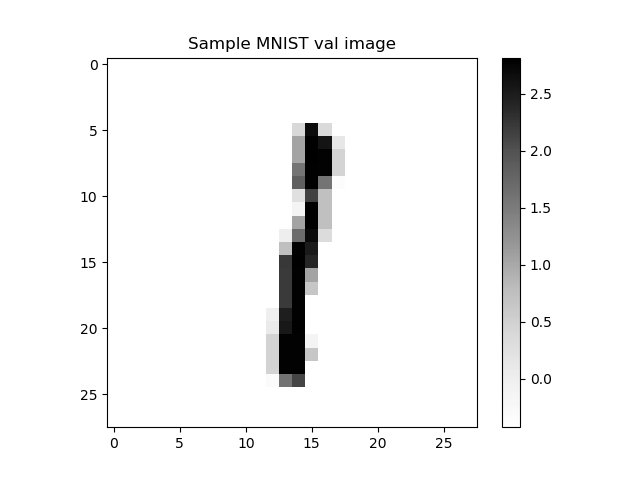

<IPython.core.display.Javascript object>


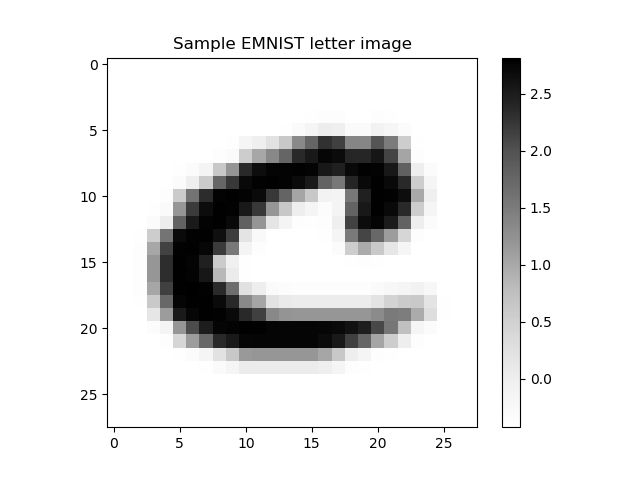

<IPython.core.display.Javascript object>


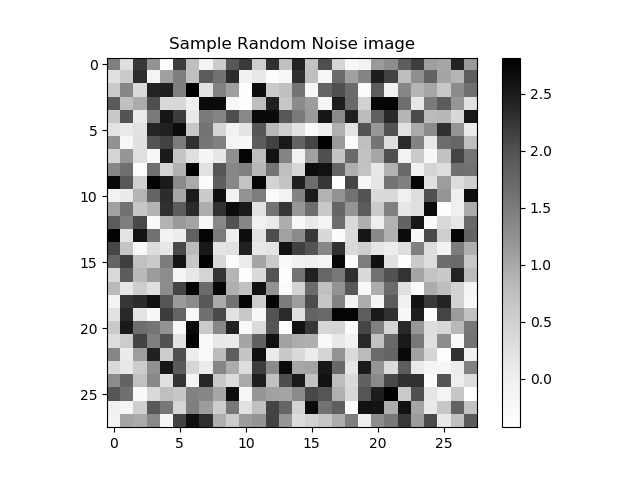

<IPython.core.display.Javascript object>


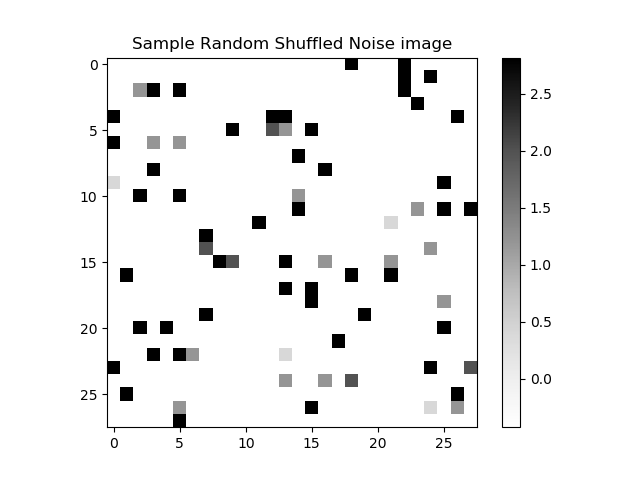

In [11]:
# plot samples
fgnh.plot_sample(mnist_val_loader, title='Sample MNIST val image')
fgnh.plot_sample(emnist_val_loader, title='Sample EMNIST letter image')
fgnh.plot_sample(rand_noise_dataloader, title='Sample Random Noise image')
fgnh.plot_sample(rand_shuffled_dataloader, title='Sample Random Shuffled Noise image')

# PART 1 - classic model 

In [12]:
# load a classic model
classic_model_path = '../Experiments/sample_models/sample_classic_full.pth'
classic_model = torch.load(classic_model_path, map_location=device)

In [13]:
# test the accuracy of the model
_ = fgnh.test(classic_model, mnist_train_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(classic_model, mnist_val_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.0320, Accuracy: 49509/50000 (99%)
Test set - Average loss: 0.0934, Accuracy: 9739/10000 (97%)


<IPython.core.display.Javascript object>


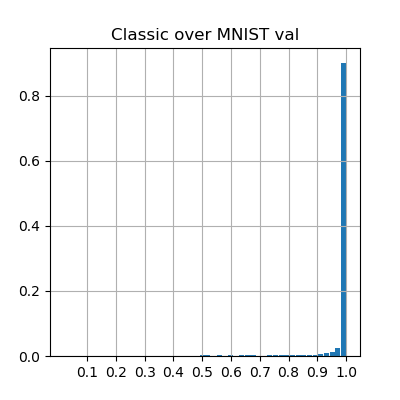

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.29278902101341025934, 0.9999924622935616388), mean=0.9822352460104473712, variance=0.0049172545029777912165, skewness=-5.4000555320904229358, kurtosis=31.411600146563036437)

percentage of confident predictions (>=0.5): 0.9961

Sample predictions
index 6239 prediction [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
index 2693 prediction [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
index 5925 prediction [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
index 2246 prediction [0.   0.   0.   0.   0.97 0.   0.   0.   0.   0.02]
index 1279 prediction [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [14]:
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(classic_model, mnist_val_loader, title='Classic over MNIST val' ,verbose=True)

<IPython.core.display.Javascript object>


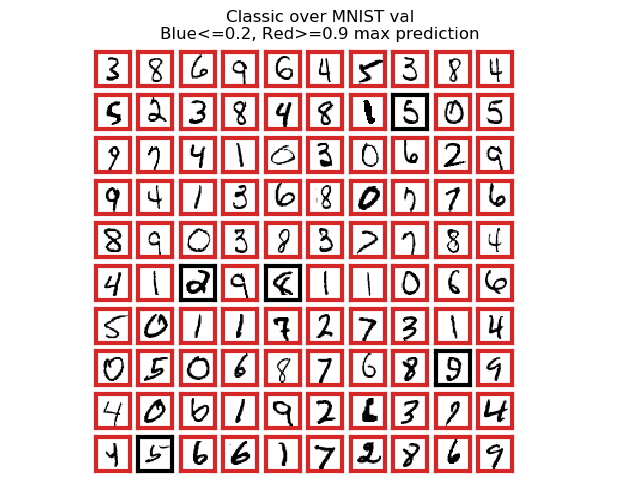

In [15]:
fgnh.plot_pred_samples_grid(classic_model, mnist_val_loader, title='Classic over MNIST val')

In [16]:
# over letters

<IPython.core.display.Javascript object>


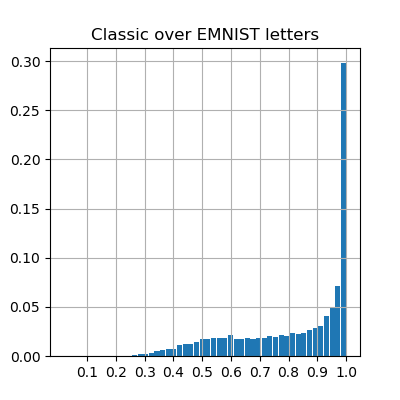

Statistical description of the predictions maximums
DescribeResult(nobs=12480, minmax=(0.22119067158881935408, 0.99999549877790761926), mean=0.81606956786205791, variance=0.038035437052881253705, skewness=-0.8472831987697619443, kurtosis=-0.52666774664512289866)

percentage of confident predictions (>=0.5): 0.9060096153846153

Sample predictions
index 11087 prediction [0.28 0.   0.   0.   0.01 0.   0.7  0.   0.   0.  ]
index 7877 prediction [0.   0.   0.   0.01 0.02 0.   0.   0.   0.37 0.59]
index 7593 prediction [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
index 12170 prediction [0.   0.   0.   0.01 0.   0.99 0.   0.   0.   0.  ]
index 11309 prediction [0.21 0.   0.   0.   0.   0.   0.   0.   0.78 0.  ]


In [17]:
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(classic_model, emnist_val_loader, title='Classic over EMNIST letters' ,verbose=True)

<IPython.core.display.Javascript object>


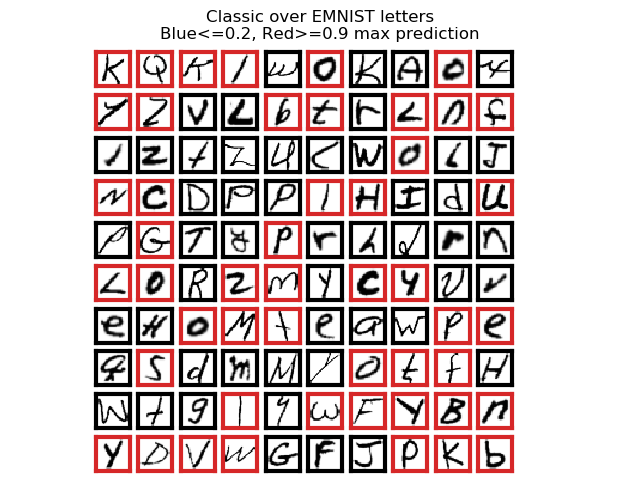

In [18]:
fgnh.plot_pred_samples_grid(classic_model, emnist_val_loader, title='Classic over EMNIST letters')

In [19]:
# over noise now

<IPython.core.display.Javascript object>


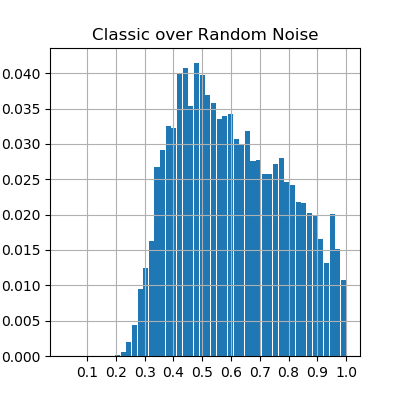

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.21052310056834904133, 0.99958760731006182036), mean=0.60629438668390984237, variance=0.0346644580026126919, skewness=0.25416716070665138202, kurtosis=-0.9438762529079706891)

percentage of confident predictions (>=0.5): 0.6543

Sample predictions
index 2856 prediction [0.   0.18 0.08 0.11 0.   0.   0.   0.63 0.   0.  ]
index 4175 prediction [0.68 0.02 0.04 0.12 0.   0.02 0.11 0.   0.01 0.  ]
index 7337 prediction [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
index 9897 prediction [0.03 0.03 0.   0.09 0.   0.1  0.75 0.   0.   0.  ]
index 2557 prediction [0.   0.09 0.01 0.3  0.   0.09 0.03 0.48 0.   0.  ]


In [20]:
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(classic_model, rand_noise_dataloader, title='Classic over Random Noise' ,verbose=True)

<IPython.core.display.Javascript object>


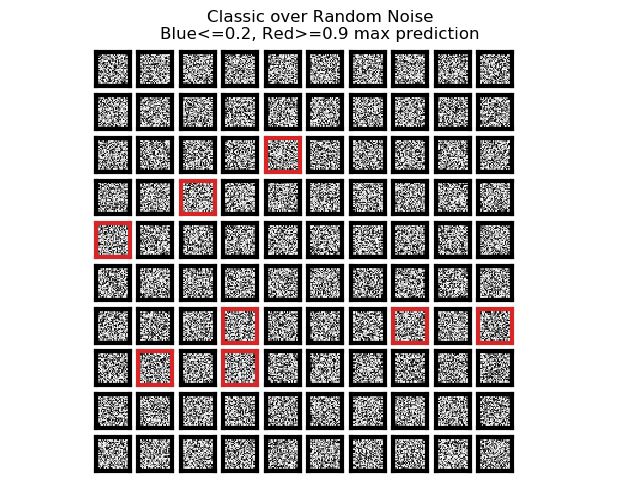

In [21]:
fgnh.plot_pred_samples_grid(classic_model, rand_noise_dataloader, title='Classic over Random Noise')

<IPython.core.display.Javascript object>


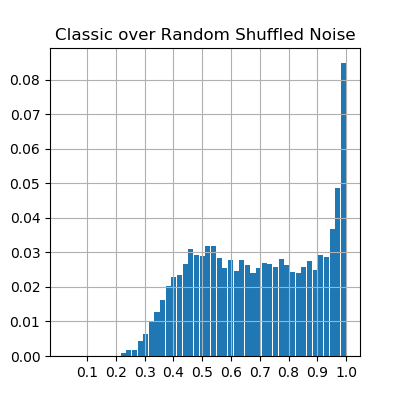

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.21623372204436940705, 0.99976140912164125434), mean=0.69423115155640735205, variance=0.042558524878814995572, skewness=-0.106042862154199602985, kurtosis=-1.2038169685739840748)

percentage of confident predictions (>=0.5): 0.7779

Sample predictions
index 2005 prediction [0.   0.01 0.01 0.51 0.   0.41 0.   0.01 0.   0.05]
index 7202 prediction [0.   0.35 0.34 0.22 0.   0.01 0.01 0.08 0.   0.  ]
index 4587 prediction [0.   0.16 0.11 0.38 0.   0.   0.   0.35 0.   0.  ]
index 1883 prediction [0.04 0.01 0.7  0.16 0.   0.03 0.04 0.01 0.   0.  ]
index 7954 prediction [0.1  0.   0.   0.82 0.   0.05 0.   0.   0.02 0.01]


In [22]:
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(classic_model, rand_shuffled_dataloader, title='Classic over Random Shuffled Noise' ,verbose=True)

<IPython.core.display.Javascript object>


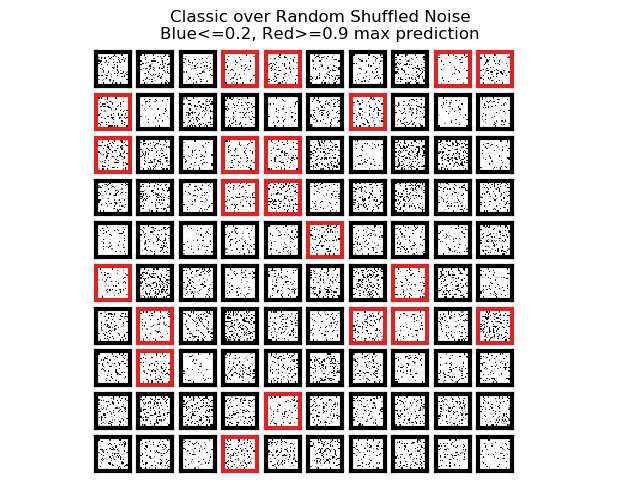

In [23]:
fgnh.plot_pred_samples_grid(classic_model, rand_shuffled_dataloader, title='Classic over Random Shuffled Noise')

# Part 2 - The converted Network

In [24]:
# print params to copy
!cat '../Experiments/sample_models/sample_classic_parameters.txt'

hidden_layer_sizes [64, 64]
drop_p 0.2
batch_size 4000
optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


In [25]:
# params from classic
hidden_layer_sizes = [64,64]
drop_p = 0.2
print("hidden layers:", hidden_layer_sizes)
print("drop prob:", drop_p)

# fgn specific params
# covariance type: sphere, diag or full/chol
covar_type = 'sphere'
print("covariance:", covar_type)
ordinal = float(2.0)
print("ordinal for norm:", ordinal)
non_lin = True
print("non linearity:", non_lin)
free_biases = True
print("free biases:", free_biases)

hidden layers: [64, 64]
drop prob: 0.2
covariance: sphere
ordinal for norm: 2.0
non linearity: True
free biases: True


In [26]:
# Initialize the fgn network
converted_fgn_model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
                                     covar_type=covar_type, ordinal=ordinal, non_lin=non_lin, free_biases=free_biases)

In [27]:
converted_fgn_model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [28]:
# convert from classic network
fgnl.convert_classic_to_fgn(classic_model, converted_fgn_model, init_factor=1e2)

In [29]:
# set to eval mode
converted_fgn_model.eval()

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [30]:
# test the accuracy of the model
# is it identical to above? (should be)
test_res = fgnh.test(converted_fgn_model, mnist_train_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

test_res = fgnh.test(converted_fgn_model, mnist_val_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.0321, Accuracy: 49509/50000 (99%)
Test set - Average loss: 0.0934, Accuracy: 9739/10000 (97%)


<IPython.core.display.Javascript object>


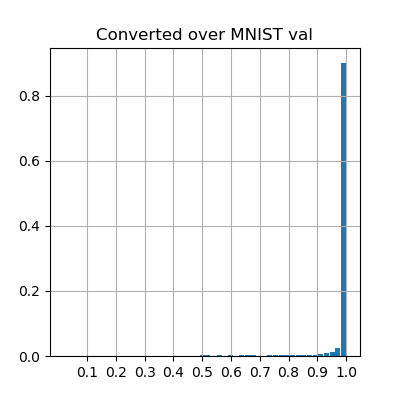

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.29278965900470243423, 0.9999924488874125899), mean=0.98223236853703007156, variance=0.0049176073970886786305, skewness=-5.399276142372088843, kurtosis=31.400392817293748367)

percentage of confident predictions (>=0.5): 0.9961

Sample predictions
index 169 prediction [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
index 9676 prediction [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
index 362 prediction [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
index 9123 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 4903 prediction [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [31]:
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(converted_fgn_model, mnist_val_loader, title='Converted over MNIST val' ,verbose=True)

<IPython.core.display.Javascript object>


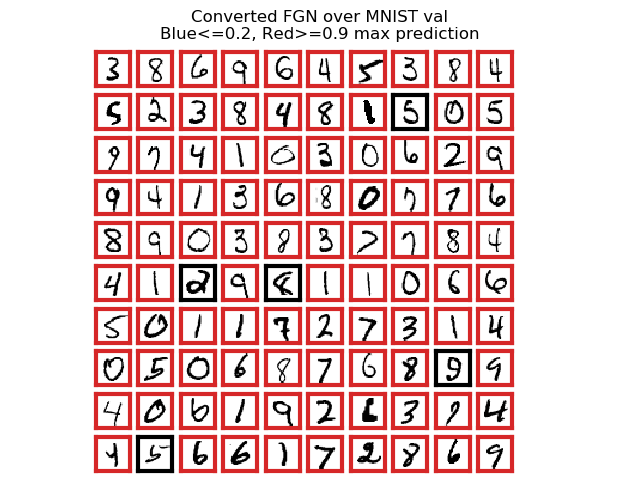

In [32]:
fgnh.plot_pred_samples_grid(converted_fgn_model, mnist_val_loader, title='Converted FGN over MNIST val')

In [33]:
# over letters now

<IPython.core.display.Javascript object>


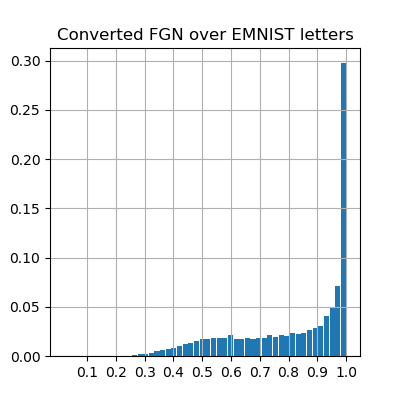

Statistical description of the predictions maximums
DescribeResult(nobs=12480, minmax=(0.22119677029526742922, 0.9999954868209375996), mean=0.8159552024395547406, variance=0.038052281831465828535, skewness=-0.8462857705576674547, kurtosis=-0.52901472279012610577)

percentage of confident predictions (>=0.5): 0.9059294871794872

Sample predictions
index 11761 prediction [0.   0.   0.   0.   0.   0.57 0.43 0.   0.   0.  ]
index 1080 prediction [0.24 0.01 0.   0.31 0.   0.23 0.2  0.   0.   0.  ]
index 1739 prediction [0.   0.   0.   0.   0.   0.01 0.97 0.   0.02 0.  ]
index 2361 prediction [0.   0.   0.   0.   0.17 0.82 0.   0.   0.01 0.  ]
index 12440 prediction [0.01 0.   0.   0.01 0.01 0.73 0.   0.   0.24 0.  ]


In [34]:
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(converted_fgn_model, emnist_val_loader, title='Converted FGN over EMNIST letters' ,verbose=True)

<IPython.core.display.Javascript object>


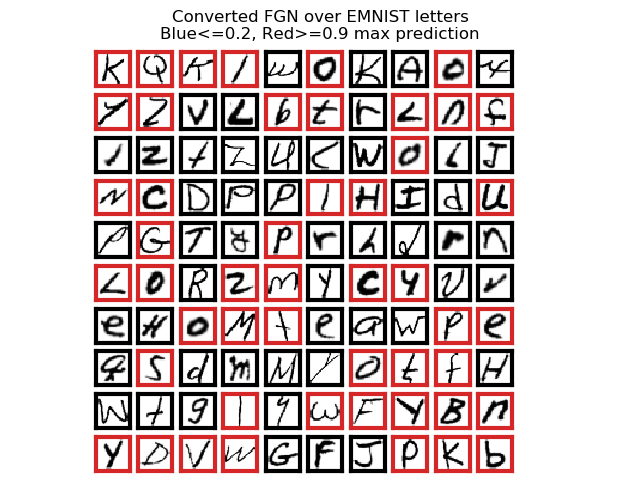

In [35]:
fgnh.plot_pred_samples_grid(converted_fgn_model, emnist_val_loader, title='Converted FGN over EMNIST letters')

In [36]:
# over noise now

<IPython.core.display.Javascript object>


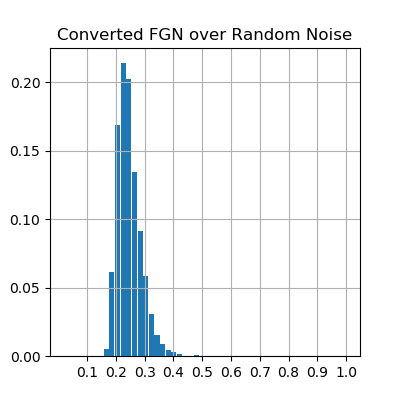

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.15792638560194087848, 0.48981973490742149204), mean=0.24639673337117170749, variance=0.0016365152614710157027, skewness=1.0236674542071064066, kurtosis=1.692868729881327622)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 3336 prediction [0.04 0.14 0.14 0.24 0.02 0.16 0.12 0.06 0.04 0.04]
index 2738 prediction [0.03 0.15 0.14 0.21 0.04 0.15 0.08 0.13 0.03 0.04]
index 8228 prediction [0.05 0.12 0.11 0.25 0.03 0.18 0.05 0.11 0.06 0.04]
index 1506 prediction [0.01 0.09 0.09 0.26 0.02 0.3  0.05 0.14 0.03 0.02]
index 2145 prediction [0.02 0.14 0.25 0.2  0.02 0.18 0.07 0.08 0.03 0.02]


In [37]:
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(converted_fgn_model, rand_noise_dataloader, title='Converted FGN over Random Noise' ,verbose=True)

<IPython.core.display.Javascript object>


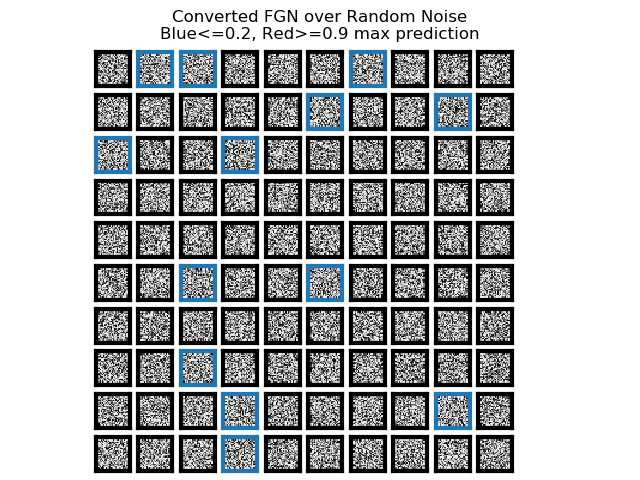

In [38]:
fgnh.plot_pred_samples_grid(converted_fgn_model, rand_noise_dataloader, title='Converted FGN over Random Noise')

<IPython.core.display.Javascript object>


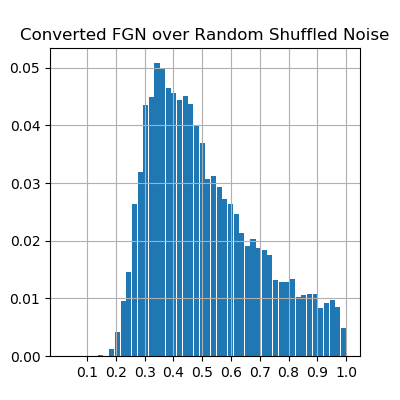

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.1518838885781995906, 0.9992378366504381053), mean=0.5098248786641877951, variance=0.034784871341108942033, skewness=0.69225266859195230617, kurtosis=-0.34700341777244880347)

percentage of confident predictions (>=0.5): 0.4388

Sample predictions
index 4798 prediction [0.01 0.43 0.04 0.4  0.   0.03 0.   0.07 0.02 0.  ]
index 7309 prediction [0.   0.11 0.08 0.2  0.   0.39 0.   0.22 0.   0.  ]
index 3306 prediction [0.   0.02 0.05 0.08 0.   0.01 0.   0.83 0.   0.01]
index 8479 prediction [0.   0.44 0.32 0.11 0.   0.06 0.   0.07 0.   0.  ]
index 4898 prediction [0.   0.   0.   0.   0.1  0.   0.22 0.67 0.   0.  ]


In [39]:
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(converted_fgn_model, rand_shuffled_dataloader, title='Converted FGN over Random Shuffled Noise' ,verbose=True)

<IPython.core.display.Javascript object>


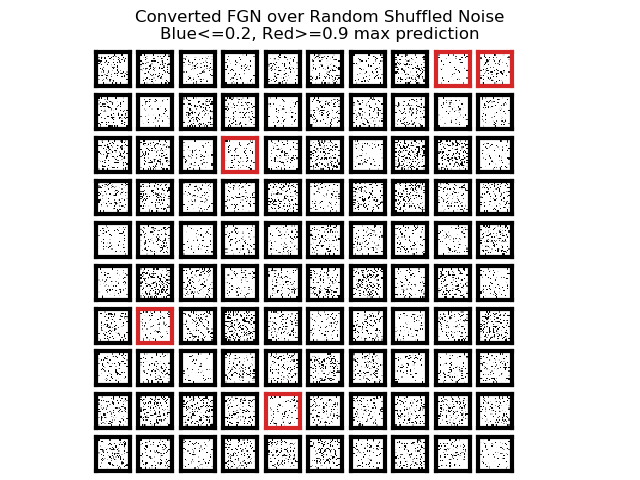

In [40]:
fgnh.plot_pred_samples_grid(converted_fgn_model, rand_shuffled_dataloader, title='Converted FGN over Random Shuffled Noise')

# Part 3 - Retraining

In [41]:
# define loss
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
lmbda_sigs = 1e1
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

# define optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, converted_fgn_model.parameters()), lr=1e-3)

lambda for l2 loss 8e-06
lambda for sigs^2 loss 10.0


In [42]:
# train the network for N epochs
epochs = 20
train_res = fgnh.train(converted_fgn_model, mnist_train_loader, 
                             cross_ent_loss, optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_val_loader)

Epoch 0 Train set - Average loss: 8190761.4844, Accuracy: 48443/50000 (97%)
Test set - Average loss: 255047.9688, Accuracy: 9750/10000 (98%)
Epoch 1 Train set - Average loss: 251552.8609, Accuracy: 48461/50000 (97%)
Test set - Average loss: 249966.3438, Accuracy: 9754/10000 (98%)
Epoch 2 Train set - Average loss: 249083.6431, Accuracy: 48512/50000 (97%)
Test set - Average loss: 248188.1875, Accuracy: 9742/10000 (97%)
Epoch 3 Train set - Average loss: 247352.4813, Accuracy: 48432/50000 (97%)
Test set - Average loss: 246492.9844, Accuracy: 9755/10000 (98%)
Epoch 4 Train set - Average loss: 245683.2634, Accuracy: 48545/50000 (97%)
Test set - Average loss: 244846.7188, Accuracy: 9766/10000 (98%)
Epoch 5 Train set - Average loss: 244051.1809, Accuracy: 48532/50000 (97%)
Test set - Average loss: 243225.4531, Accuracy: 9757/10000 (98%)
Epoch 6 Train set - Average loss: 242433.5831, Accuracy: 48570/50000 (97%)
Test set - Average loss: 241608.8281, Accuracy: 9752/10000 (98%)
Epoch 7 Train set -

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(histories[k], marker='.', linestyle=' ',)


<IPython.core.display.Javascript object>


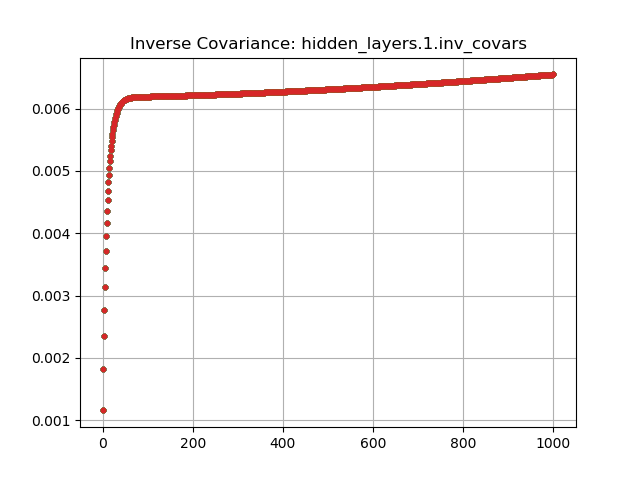

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(1.0/histories[k], marker='.', linestyle=' ')


<IPython.core.display.Javascript object>


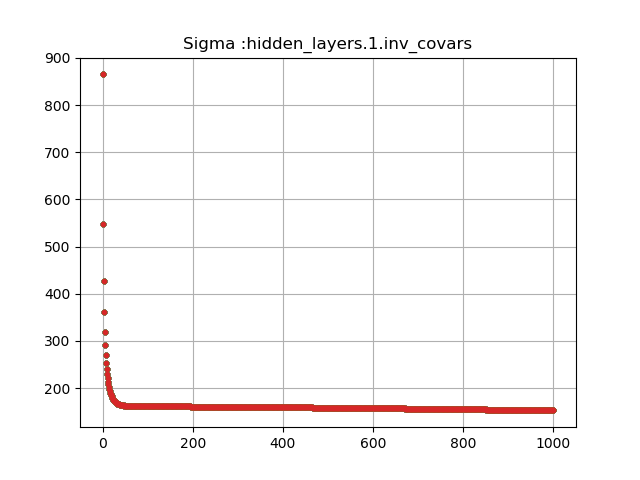

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(histories[k], marker='.', linestyle=' ',)


<IPython.core.display.Javascript object>


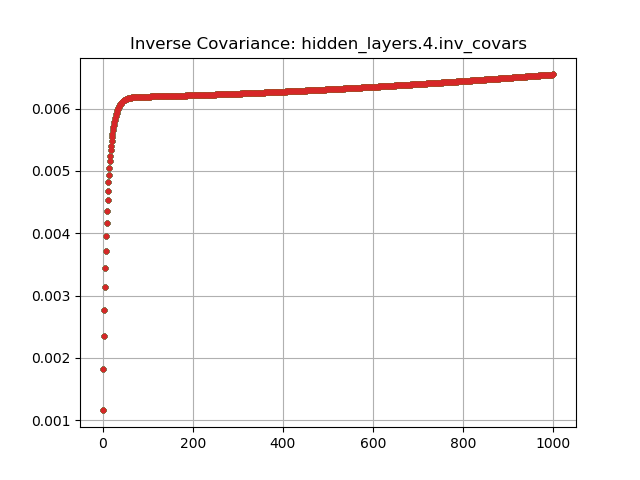

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(1.0/histories[k], marker='.', linestyle=' ')


<IPython.core.display.Javascript object>


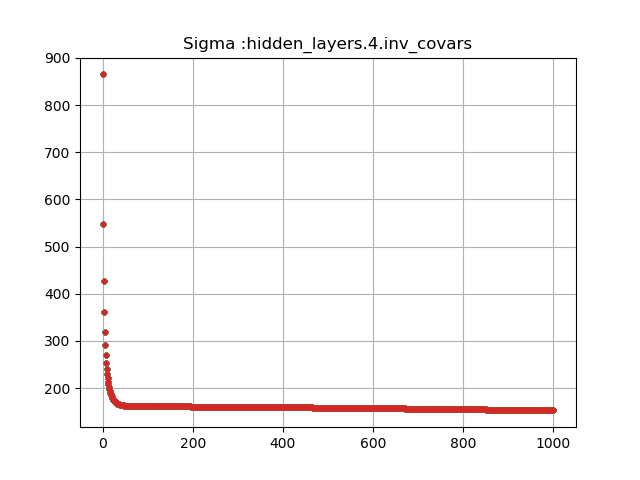

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(histories[k], marker='.', linestyle=' ',)


<IPython.core.display.Javascript object>


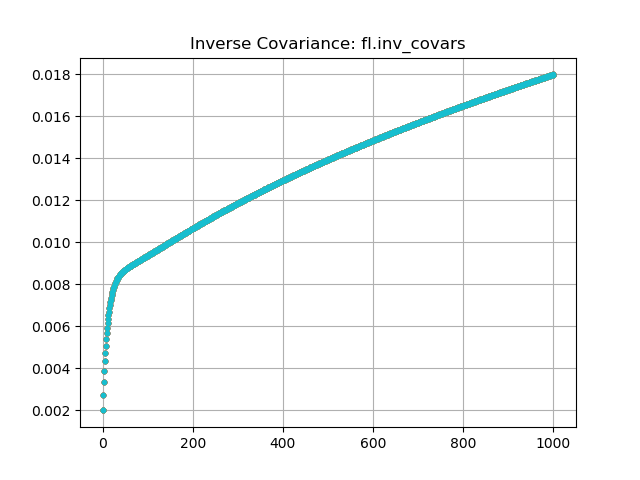

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(1.0/histories[k], marker='.', linestyle=' ')


<IPython.core.display.Javascript object>


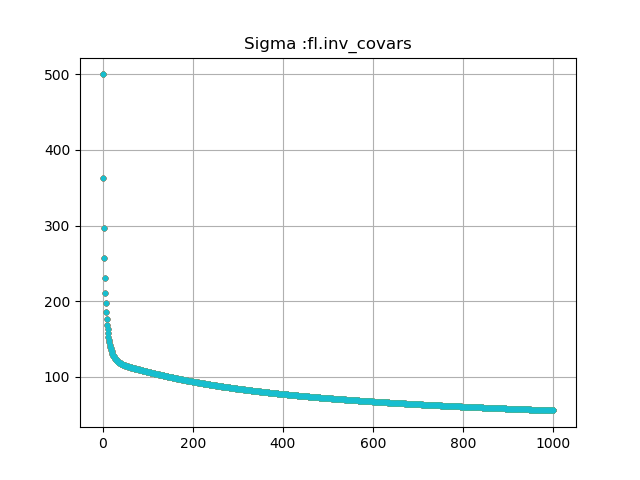

In [43]:
# check that inv_covar went up <=> sigmas went down
fgnl.plot_sigmas_histories(train_res['histories'])

In [44]:
# check accuracies
test_res = fgnh.test(converted_fgn_model, mnist_train_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

test_res = fgnh.test(converted_fgn_model, mnist_val_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.0206, Accuracy: 49715/50000 (99%)
Test set - Average loss: 0.0853, Accuracy: 9760/10000 (98%)


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


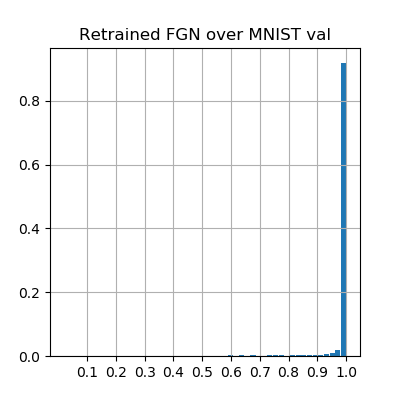

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.100524511863004408795, 0.99999602390588480087), mean=0.9845384189922089016, variance=0.0048075424231044643104, skewness=-6.392149489958998524, kurtosis=48.051338254776949796)

percentage of confident predictions (>=0.5): 0.996

Sample predictions
index 7075 prediction [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
index 5314 prediction [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
index 2757 prediction [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
index 4160 prediction [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
index 9878 prediction [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


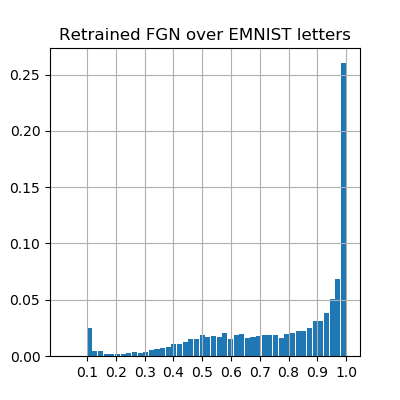

Statistical description of the predictions maximums
DescribeResult(nobs=12480, minmax=(0.1, 0.9999885124738566844), mean=0.7737887065262203522, variance=0.058058920072280372805, skewness=-1.0244589358406540877, kurtosis=0.18365734366739432278)

percentage of confident predictions (>=0.5): 0.8483974358974359

Sample predictions
index 2806 prediction [0.   0.   0.95 0.   0.   0.   0.   0.   0.05 0.  ]
index 6147 prediction [0.46 0.   0.14 0.38 0.   0.   0.   0.01 0.   0.01]
index 504 prediction [0.   0.   0.   0.   0.   0.08 0.9  0.   0.01 0.  ]
index 6136 prediction [0.01 0.   0.01 0.   0.01 0.03 0.91 0.   0.02 0.  ]
index 728 prediction [0.   0.02 0.06 0.01 0.26 0.29 0.31 0.04 0.   0.  ]


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


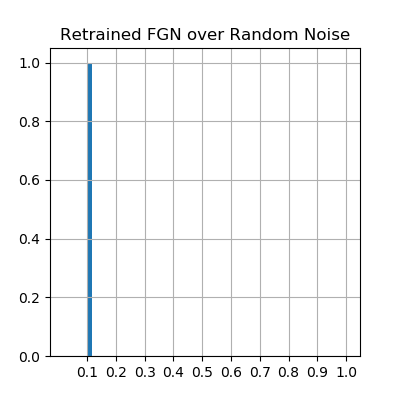

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.1, 0.1), mean=0.10000000000000000001, variance=4.5922340313026908473e-41, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 5062 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6144 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1453 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4086 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4694 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


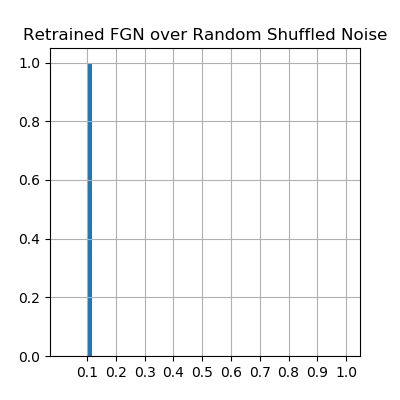

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.1, 0.100014508699456069384), mean=0.100000001722966016545, variance=2.1340998300027762205e-14, skewness=98.06322759121457509, kurtosis=9724.827198624936333)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 9585 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2945 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3304 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 9033 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8691 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [45]:
# check histograms over MNIST, letters, noise, shuffled
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(converted_fgn_model, mnist_val_loader, title='Retrained FGN over MNIST val', verbose=True)
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(converted_fgn_model, emnist_val_loader, title='Retrained FGN over EMNIST letters' ,verbose=True)
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(converted_fgn_model, rand_noise_dataloader, title='Retrained FGN over Random Noise', verbose=True)
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(converted_fgn_model, rand_shuffled_dataloader, title='Retrained FGN over Random Shuffled Noise', verbose=True)

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/fgn_helper_lib/plot_pred_samples_grid.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=10, ncols=10)


<IPython.core.display.Javascript object>


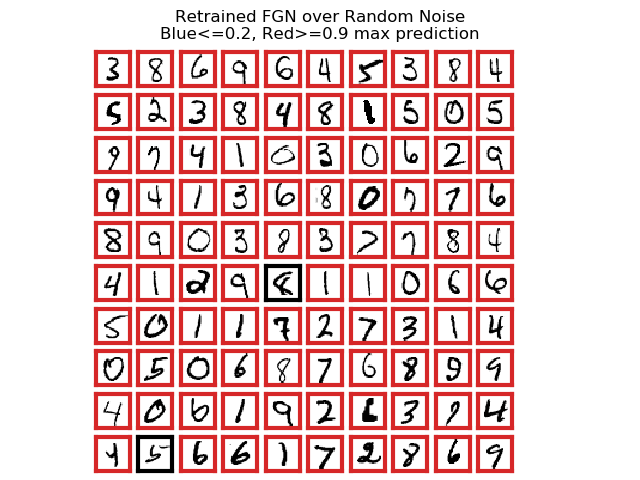

In [46]:
fgnh.plot_pred_samples_grid(converted_fgn_model, mnist_val_loader, title='Retrained FGN over Random Noise')

<IPython.core.display.Javascript object>


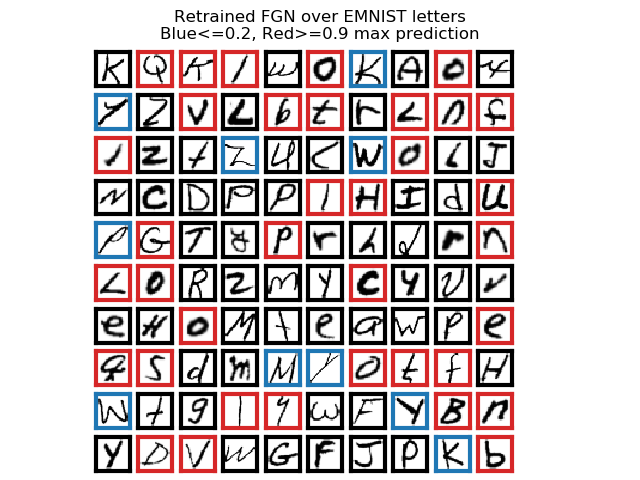

In [47]:
fgnh.plot_pred_samples_grid(converted_fgn_model, emnist_val_loader, title='Retrained FGN over EMNIST letters')

<IPython.core.display.Javascript object>


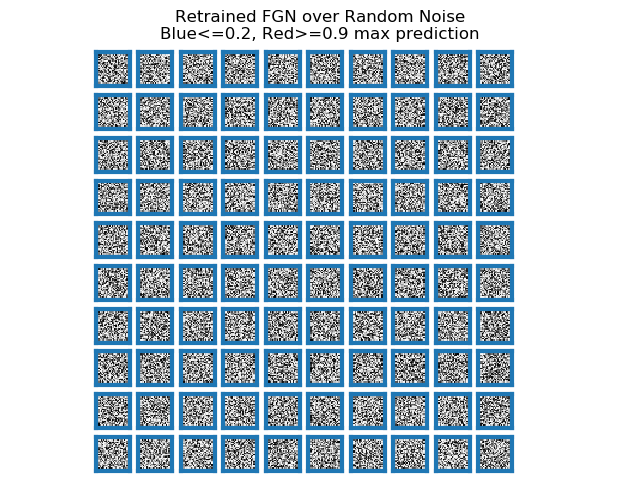

In [48]:
fgnh.plot_pred_samples_grid(converted_fgn_model, rand_noise_dataloader, title='Retrained FGN over Random Noise')

<IPython.core.display.Javascript object>


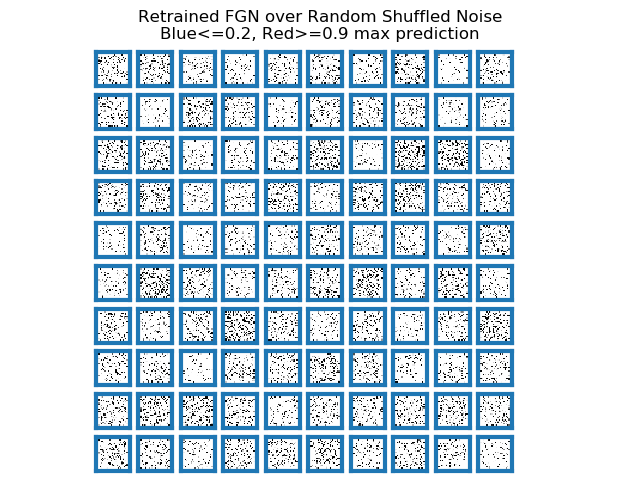

In [49]:
fgnh.plot_pred_samples_grid(converted_fgn_model, rand_shuffled_dataloader, title='Retrained FGN over Random Shuffled Noise')

# Part 4 - Long retrained model

In [50]:
# load heavily retrained model
ret_long_fgn_model_path = '../Experiments/sample_models/sample_fgn_converted+retrained_full.pth'
ret_long_fgn_model = torch.load(ret_long_fgn_model_path, map_location=torch.device(device))

In [51]:
# check accuracies
test_res = fgnh.test(ret_long_fgn_model, mnist_train_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

test_res = fgnh.test(ret_long_fgn_model, mnist_val_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.0174, Accuracy: 49739/50000 (99%)
Test set - Average loss: 0.0766, Accuracy: 9806/10000 (98%)


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


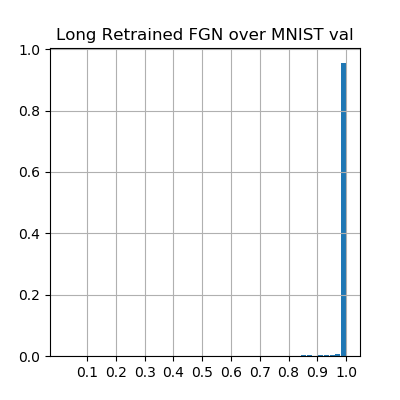

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.1, 0.99999983932636181866), mean=0.99016408069698914706, variance=0.00369766197599524115, skewness=-8.410776888220885646, kurtosis=83.6409678074379577)

percentage of confident predictions (>=0.5): 0.9962

Sample predictions
index 1932 prediction [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
index 8791 prediction [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
index 4410 prediction [0.   0.   0.   0.   0.93 0.   0.   0.   0.   0.07]
index 6778 prediction [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
index 7359 prediction [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


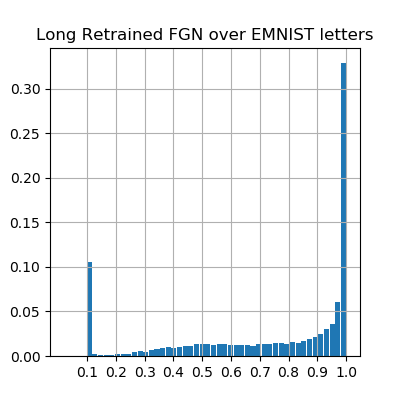

Statistical description of the predictions maximums
DescribeResult(nobs=12480, minmax=(0.1, 0.99999863616704254277), mean=0.7367366090153037684, variance=0.092783644454540098375, skewness=-0.9535703927412893388, kurtosis=-0.4358045014599151194)

percentage of confident predictions (>=0.5): 0.7717147435897436

Sample predictions
index 11752 prediction [0.   0.98 0.01 0.   0.   0.   0.   0.   0.   0.  ]
index 1221 prediction [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
index 3213 prediction [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
index 5217 prediction [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
index 8224 prediction [0.09 0.11 0.11 0.1  0.1  0.1  0.11 0.1  0.1  0.09]


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


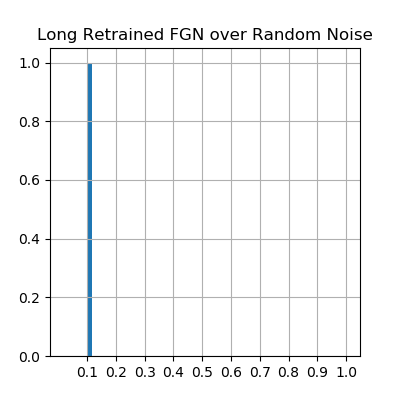

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.1, 0.1), mean=0.10000000000000000001, variance=4.5922340313026908473e-41, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 4286 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4749 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6987 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1808 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5654 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


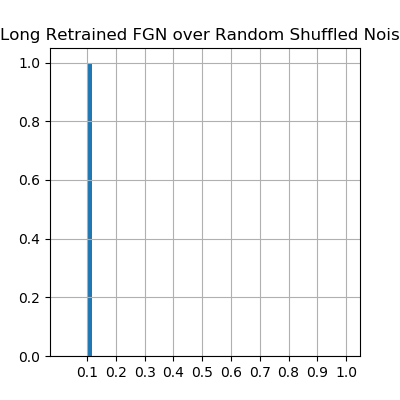

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.1, 0.1), mean=0.10000000000000000001, variance=4.5922340313026908473e-41, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 7262 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5994 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7720 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1930 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2004 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [52]:
# check histograms over MNIST, letters, noise, shuffled
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(ret_long_fgn_model, mnist_val_loader, title='Long Retrained FGN over MNIST val', verbose=True)
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(ret_long_fgn_model, emnist_val_loader, title='Long Retrained FGN over EMNIST letters' ,verbose=True)
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(ret_long_fgn_model, rand_noise_dataloader, title='Long Retrained FGN over Random Noise', verbose=True)
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(ret_long_fgn_model, rand_shuffled_dataloader, title='Long Retrained FGN over Random Shuffled Noise', verbose=True)

<IPython.core.display.Javascript object>


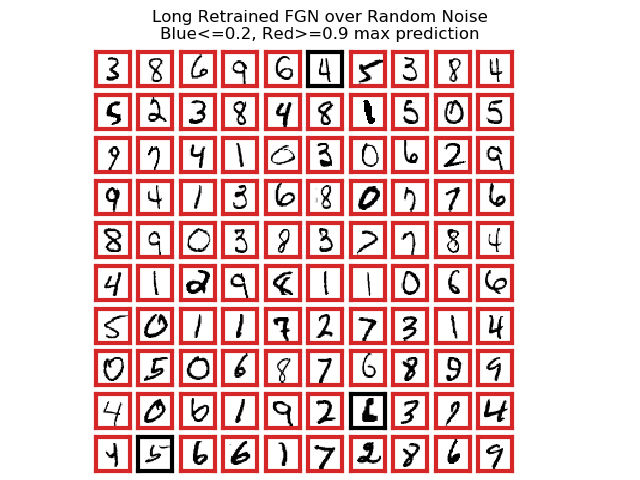

<IPython.core.display.Javascript object>


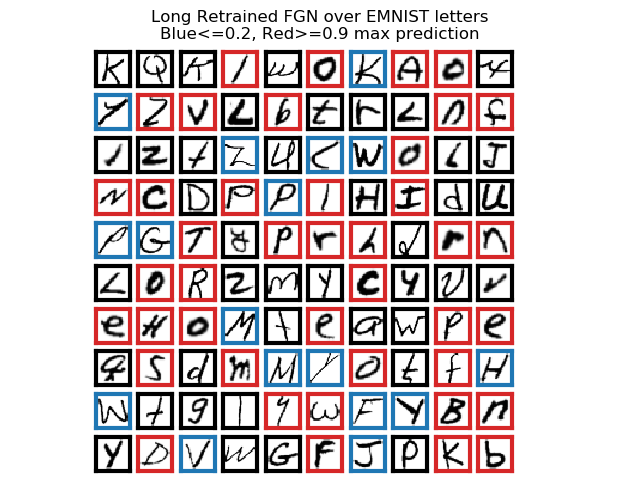

<IPython.core.display.Javascript object>


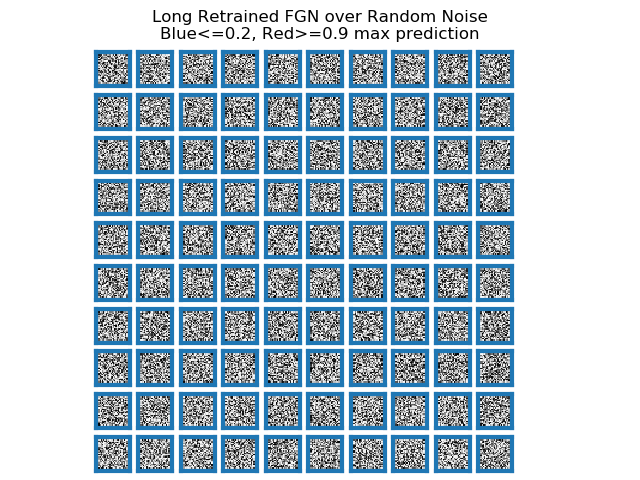

<IPython.core.display.Javascript object>


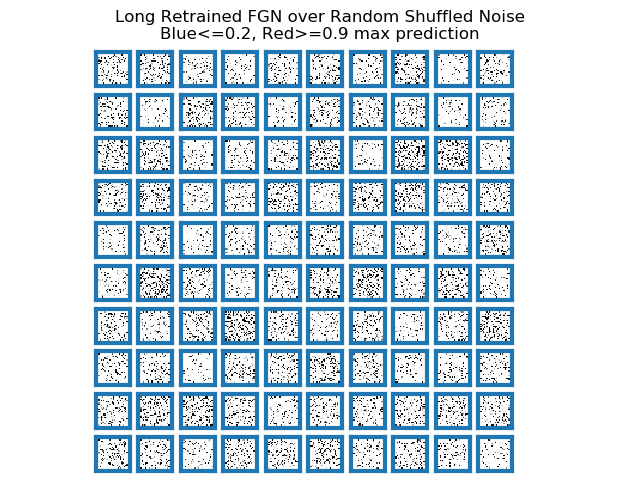

In [53]:
fgnh.plot_pred_samples_grid(ret_long_fgn_model, mnist_val_loader, title='Long Retrained FGN over Random Noise')
fgnh.plot_pred_samples_grid(ret_long_fgn_model, emnist_val_loader, title='Long Retrained FGN over EMNIST letters')
fgnh.plot_pred_samples_grid(ret_long_fgn_model, rand_noise_dataloader, title='Long Retrained FGN over Random Noise')
fgnh.plot_pred_samples_grid(ret_long_fgn_model, rand_shuffled_dataloader, title='Long Retrained FGN over Random Shuffled Noise')